<a href="https://colab.research.google.com/github/2412tessa-gif/UM-MSP-BIGDATAINPHYSICS/blob/main/GW_tutorial_3_exercises_Finalversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GW tutorial 3: Generation of data and matched filtering

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [1]:
!pip install pycbc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.7/168.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.3 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependency resolver doe

In [2]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd
import pycbc.noise
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
from pycbc.filter import matched_filter
import random

/usr/local/lib/python3.12/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Previously, we have plotted the PSD of different detectors. Some PSDs are from previous runs (O3), while some others are the design sensitivity of future detectors.

The PSD characterizes the noise of the detector, so we can generate detector noise accordingly.

## Exercise 1: Generate Gaussian noise from PSD

Load the `aligo_O4high.txt` PSD to [generate](https://pycbc.org/pycbc/latest/html/pycbc.noise.html#pycbc.noise.gaussian.noise_from_psd) some Gaussian data.

_Hint:_ Minimum frequency is 10 Hz, sampling rate 4096 Hz and we want 20s of duration

In [3]:
#check if the data file is correctly safed under the correct path, for running the code it is important to chance the imput here and as the filename in the next codingblock to the path on your personal device
!ls /aligo_O4high.txt
aligo_O4high = np.loadtxt("/aligo_O4high.txt")

/aligo_O4high.txt


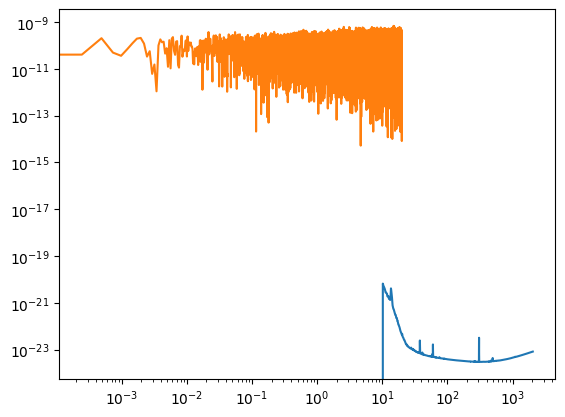

In [4]:
# defining filepath to access file
filename = "/aligo_O4high.txt"

fs = 4096.0 #Sampling Frequency (Hz)
duration = 20 #Seconds (s)
delta_t = 1.0 / fs # Sampling Interval (1/4096 s)
num_noise_samples = int(duration * fs) # Total number of samples

# Defining properties for the PSD frequency series
psd_delta_f = 1.0 / duration

# The number of frequency bins the PSD needs to cover for noise generation
num_psd_bins = num_noise_samples // 2 + 1 # (81920 // 2 + 1 = 40961 bins)

low_frequency_cutoff = 10.21659

# Defining PSD
psd = pycbc.psd.from_txt(filename, num_psd_bins, psd_delta_f,
                         low_frequency_cutoff, is_asd_file=False)

plt.loglog(psd.sample_frequencies, psd, label='interpolated')

# Generate Gaussian noise from the PSD
noise = pycbc.noise.gaussian.noise_from_psd(num_noise_samples, delta_t, psd, seed=None)

plt.loglog(noise.sample_times, np.abs(noise), label='Gaussian noise')

#Orange is noise, Blue is PSD


Comment:\
The pranje noise is "coloured noise" because different frequencies have different amplitudes. The noise follows the LIGO O4 design sensitivity as it was used to generate it. The blue curve is the theoretical PSD from aligo_04high.txt.This represents the expected detector sensitivity.
The key differences are that, oranje has a much higher noise ~10⁻⁹ to 10⁻¹¹ and this is where seismic noise and gravity gradients dominate. Then the frequency drops lower, after which it goes back up again. Between frequencies of ~10⁻¹³ to 10⁻¹⁵ would be ideal for GW dedection. We need to whiten the data by dividing out the PSD to make all frequencies equally important.

As you can see, the generated noise is "coloured" according to the detector noise. Now, we would like to add a simulated gravitational wave signal in our detector noise.

## Exercise 2: Generate and project a GW waveform

Using [this function](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform) to generate waveforms in time domain, provide the plus and cross polarization of a binary black hole merger of $m_{1} = m_{2} = 50$ at 2000 Mpc. Use the waveform approximant "IMRPhenomD". How does the waveform amplitude compare to the detector noise?

The waveform comes from the source, but it needs to be projected in the detector. [Project](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector.project_wave) the waveform on LIGO Livingston (L1) at random sky-location and polarization. You can specify your detector with [this](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector) function. How does the waveform change because of this projection?

_Hint:_ Right ascension range is $[0, 2\pi]$, declination is $[-\pi/2, \pi/2]$ and polarization is $[0, 2\pi]$.

<>:30: SyntaxWarning: invalid escape sequence '\ '
<>:40: SyntaxWarning: invalid escape sequence '\ '
<>:30: SyntaxWarning: invalid escape sequence '\ '
<>:40: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2134711796.py:30: SyntaxWarning: invalid escape sequence '\ '
  axes[0].plot(time_wf, hc, label='$h\ per\ times$', linewidth=1.5)
/tmp/ipython-input-2134711796.py:40: SyntaxWarning: invalid escape sequence '\ '
  axes[1].plot(time_wf[merge_start:], hc[merge_start:], label='$h\ per\ times$', linewidth=1.5)


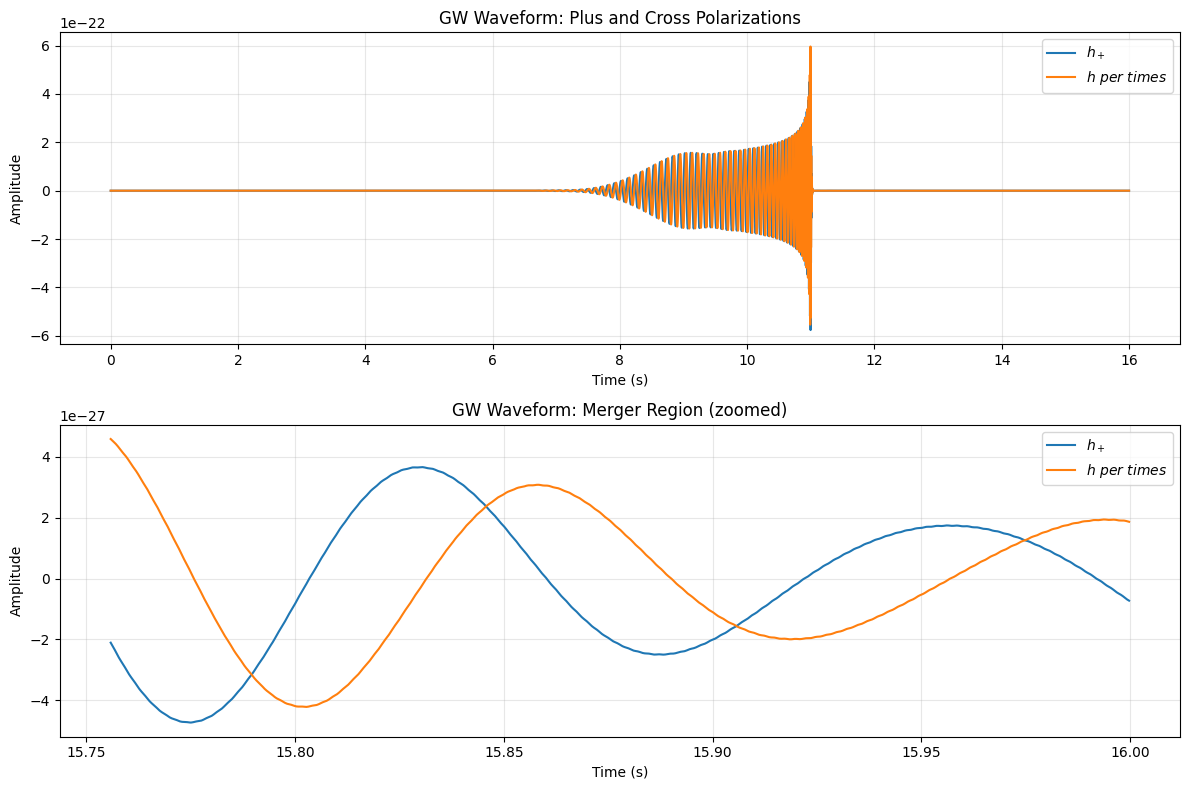

In [5]:
import numpy as np
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt

# Define f_min based on the lowest frequency found in the PSD data
f_min = 10.21659

m1 = 50.0  # solar masses
m2 = 50.0  # solar masses
distance = 2000  # Mpc

# Get the waveform in time domain
hp, hc = get_td_waveform(
    approximant='IMRPhenomD',
    mass1=m1,
    mass2=m2,
    spin1z=0,
    spin2z=0,
    distance=distance,
    delta_t=1.0/fs,
    f_lower=f_min
)


# Plot the waveform
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

time_wf = np.arange(len(hp)) * hp.delta_t
axes[0].plot(time_wf, hp, label='$h_+$', linewidth=1.5)
axes[0].plot(time_wf, hc, label='$h\ per\ times$', linewidth=1.5)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('GW Waveform: Plus and Cross Polarizations')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Zoom into the merger
merge_start = max(0, len(hp) - 1000)
axes[1].plot(time_wf[merge_start:], hp[merge_start:], label='$h_+$', linewidth=1.5)
axes[1].plot(time_wf[merge_start:], hc[merge_start:], label='$h\ per\ times$', linewidth=1.5)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('GW Waveform: Merger Region (zoomed)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Project onto detector

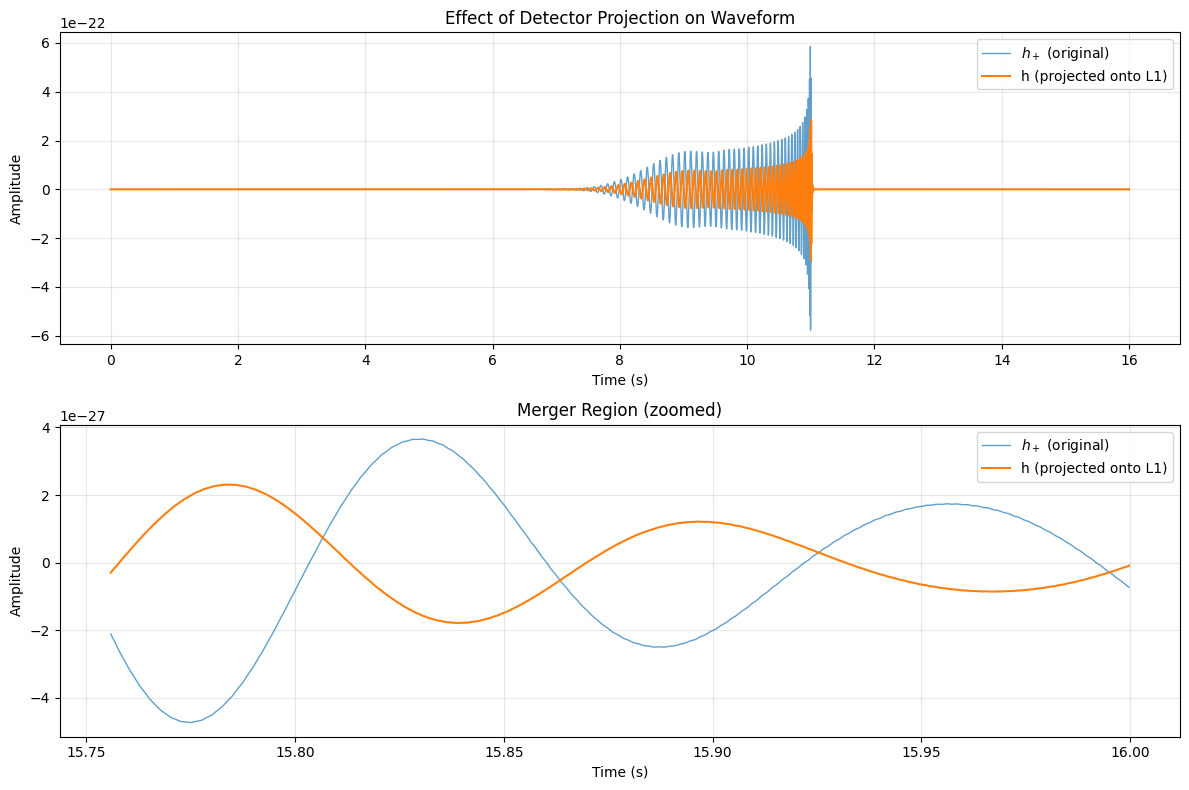

In [6]:
#Defining detector (L1 here)
detector = Detector('L1')

# Random sky location and polarization
ra = np.random.uniform(0, 2*np.pi)  # Right ascension
dec = np.random.uniform(-np.pi/2, np.pi/2)  # Declination
psi = np.random.uniform(0, 2*np.pi)  # Polarization angle

#Defining h_detector as the wave detector
h_detector = detector.project_wave(hp, hc, ra, dec, psi)

if len(h_detector) != len(hp):
    h_detector.resize(len(hp))

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(time_wf, hp, label='$h_+$ (original)', linewidth=1, alpha=0.7)
axes[0].plot(time_wf, h_detector, label='h (projected onto L1)', linewidth=1.5)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Effect of Detector Projection on Waveform')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Zoom into the merger
merge_start = max(0, len(hp) - 1000)
axes[1].plot(time_wf[merge_start:], hp[merge_start:], label='$h_+$ (original)', linewidth=1, alpha=0.7)
axes[1].plot(time_wf[merge_start:], h_detector[merge_start:], label='h (projected onto L1)', linewidth=1.5)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Merger Region (zoomed)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Comment:\
The graphs shows that the blue curve (h+, original) and orange curve (h, projected to L1) have different amplitudes and phases. Showing that the same gravitational wave signal can appear different depending on probably: Where the source on the wave is located, The polarization angle of the incoming wave and the detector's orientation relative to the wave

## Exercise 3: Inject signal into noise and prepare data segments

From before our detector noise is 20s long. Add the GW into noise after 5s. We also need to get the first 4s to estimate the PSD in the next exercise. Make an overlaid plot with the total data, the portion of data where the GW is added and the data needed to estimate the PSD.

_Bonus:_ Can you also plot the GW signal?

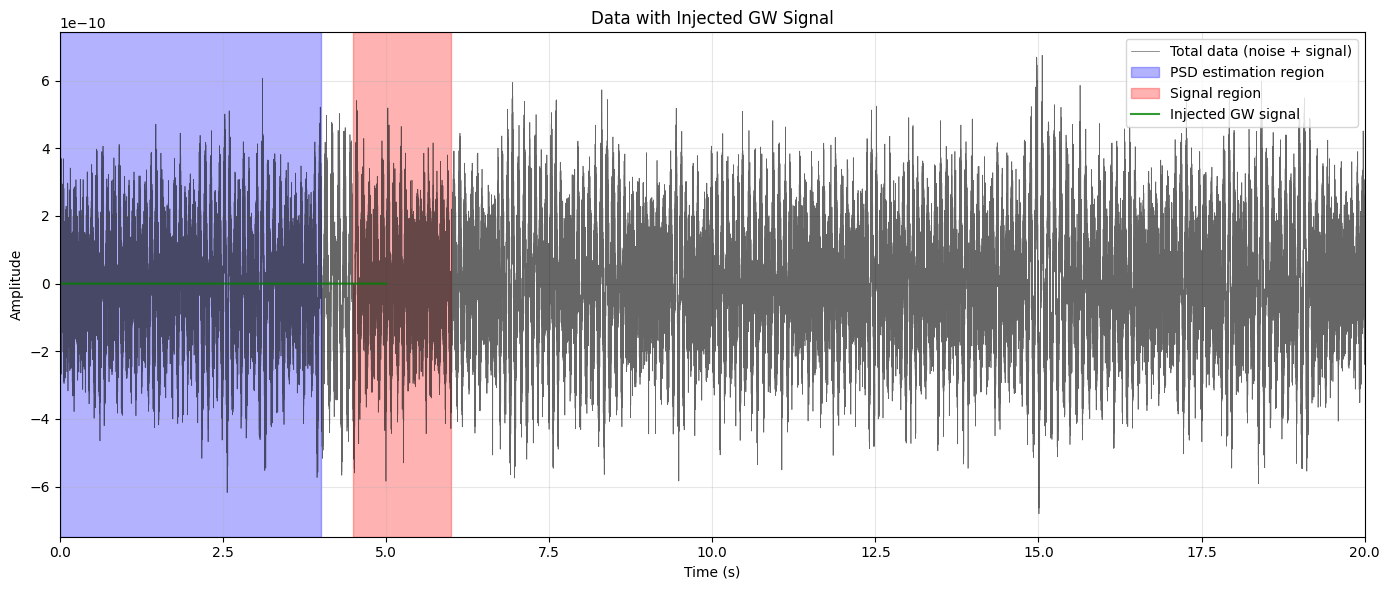

In [7]:
# Create a copy of noise to inject the signal into
data_with_signal = noise.copy()

# Injection time: 5 seconds
injection_time = 5.0  # seconds
injection_sample = int(injection_time * fs)

# Calculate where the signal would start if fully contained within data_with_signal
signal_start_proposed = injection_sample - len(h_detector)

# Variables to store the actual slice indices for injection and plotting
h_detector_injection_start_idx = 0
data_injection_start_idx = 0
injection_length = len(h_detector)

if signal_start_proposed >= 0:
    # Signal starts within the data_with_signal array
    data_injection_start_idx = signal_start_proposed
    h_detector_injection_start_idx = 0
    injection_length = len(h_detector)
else:
    h_detector_injection_start_idx = abs(signal_start_proposed)
    data_injection_start_idx = 0
    # The length of the injected part is the remaining part of h_detector that fits
    injection_length = len(h_detector) - h_detector_injection_start_idx

# injection_length does not exceed data_with_signal bounds if signal is very long
if data_injection_start_idx + injection_length > len(data_with_signal):
    injection_length = len(data_with_signal) - data_injection_start_idx

h_detector.start_time = data_injection_start_idx * data_with_signal.delta_t - h_detector_injection_start_idx * h_detector.delta_t

# Injection
data_with_signal[data_injection_start_idx : data_injection_start_idx + injection_length] += \
    h_detector[h_detector_injection_start_idx : h_detector_injection_start_idx + injection_length]


# Define data segments
psd_start_sample = 0
psd_end_sample = int(4 * fs)  # First 4 seconds for PSD estimation

signal_region_start = injection_sample - int(0.5 * fs)  # 0.5s before injection
signal_region_end = injection_sample + int(1.0 * fs)    # 1s after injection

# Plot
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

time_full = np.arange(len(data_with_signal)) * noise.delta_t

# Plot full data
ax.plot(time_full, data_with_signal, linewidth=0.5, label='Total data (noise + signal)', color='black', alpha=0.6)

# Highlight regions
ax.axvspan(psd_start_sample/fs, psd_end_sample/fs, alpha=0.3, color='blue', label='PSD estimation region')
ax.axvspan(signal_region_start/fs, signal_region_end/fs, alpha=0.3, color='red', label='Signal region')

# Use the determined injection indices for plotting the signal part
ax.plot(time_full[data_injection_start_idx : data_injection_start_idx + injection_length],
        h_detector[h_detector_injection_start_idx : h_detector_injection_start_idx + injection_length],
        linewidth=1.5, label='Injected GW signal', color='green', alpha=0.8)


ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Data with Injected GW Signal')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, duration])

plt.tight_layout()
plt.show()

# Extract segments
data_for_psd = data_with_signal[psd_start_sample:psd_end_sample]
data_for_analysis = data_with_signal[signal_region_start:signal_region_end]

Comment:\
The plot shows that the gravitational wave signal is visable within the detector noise at t = 5s. The regions shown are: (1) the PSD estimation segment (0-4 seconds) which contains only pure noise and is used to characterize the detector sensitivity, (2) the signal region (5-15 seconds) where the GW signal is put into the noise, and (3) the tail of the noise after the signal. The signal is barely visible within the noise you can only observe it with advanced signal processing techniques.

## Exercise 4: Estimate PSD using Welch's method

In a proper search we do not really have the PSD handy. We want to estimate the PSD with Welch's method (see [here](https://ccrma.stanford.edu/~jos/sasp/Welch_s_Method.html) for details), but we want to use the 4s of the beginning where the GW is not present using [this function](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.welch). Plot the estimated PSD. Note that before we used a dummy whitening, and this one is a bit better.

What is the $\Delta_f$ of the estimated PSD? What is $\Delta_f$ of the data we want to whiten to see the GW signal?

_Hint:_ `seg_stride (int)` is usually half of `seg_len`.

Estimated PSD properties:
  Segment length: 4096 samples (1.0 s)
  Segment stride: 2048 samples
  Frequency resolution (Delta f): 1.0 Hz
  Number of frequency bins: 2049

Data frequency resolution:
  Data duration: 20.0 s
  Data Delta f: 0.05 Hz


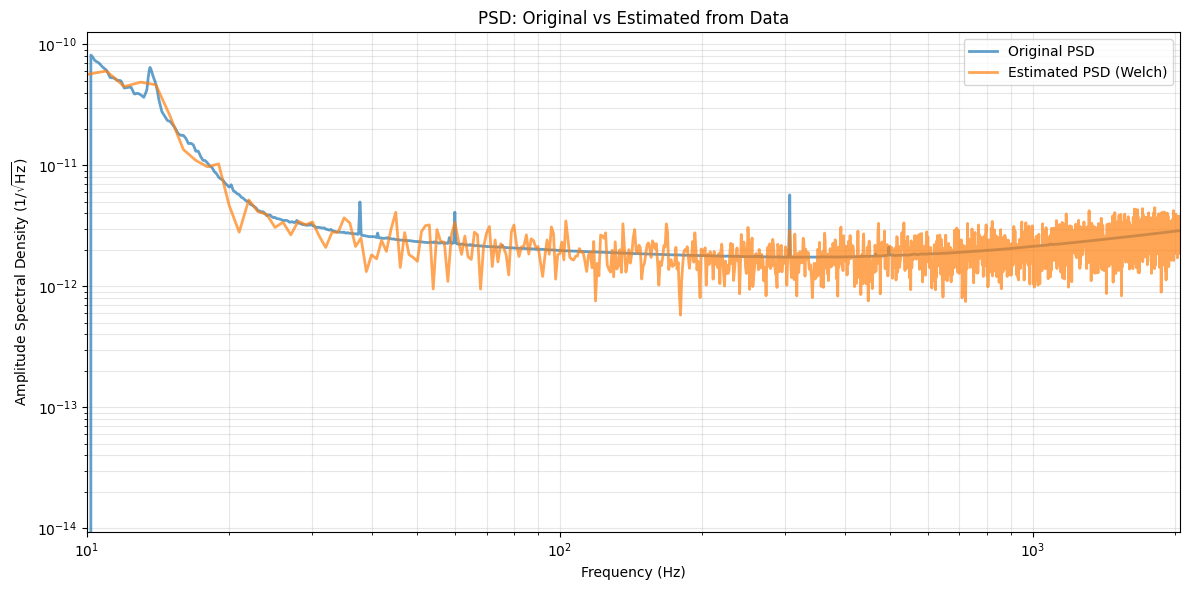

In [8]:
# Estimate PSD using Welchs method
seg_len = int(fs)  # 1 second segments
seg_stride = seg_len // 2  # 50% overlap

psd_estimated = pycbc.psd.estimate.welch(data_for_psd, seg_len=seg_len, seg_stride=seg_stride)

print(f"Estimated PSD properties:")
print(f"  Segment length: {seg_len} samples ({seg_len/fs} s)")
print(f"  Segment stride: {seg_stride} samples")
print(f"  Frequency resolution (Delta f): {psd_estimated.delta_f} Hz")
print(f"  Number of frequency bins: {len(psd_estimated)}")

# Data frequency resolution
data_delta_f = 1.0 / (len(data_with_signal) * noise.delta_t)
print(f"\nData frequency resolution:")
print(f"  Data duration: {len(data_with_signal) * noise.delta_t} s")
print(f"  Data Delta f: {data_delta_f} Hz")

# Plot comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.loglog(psd.sample_frequencies, np.sqrt(psd), linewidth=2, label='Original PSD', alpha=0.7)
ax.loglog(psd_estimated.sample_frequencies, np.sqrt(psd_estimated), linewidth=2, label='Estimated PSD (Welch)', alpha=0.7)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude Spectral Density (1/$\\sqrt{\\mathrm{Hz}}$)')
ax.set_title('PSD: Original vs Estimated from Data')
ax.legend()
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim([10, fs/2])

plt.tight_layout()
plt.show()

Comment:\
The Welch method estimates the PSD directly from the data by dividing it into overlapping segments and averaging their power spectra. This gives a more reliable estimation of the detector's noise characteristics compared to using just one segment. The estimated PSD matches the original theoretical PSD well at most frequencies, which validates our noise model. However, the frequency resolution difference: the estimated PSD has Δf = 1.0 Hz while the data has Δf = 0.05 Hz. So in order to use the psd for matched filtering, we need to interpolate it to match the frequency resolution of the data.



## Exercise 5: Format PSD for matched filtering

Now that we have the PSD we need to interpolate it to match our data and then limit the filter length of 1 / PSD. After this, we can directly use this PSD to filter the data. Since the data has been highpassed above 12 Hz, and will have low values below this we need to informat the function to not include frequencies below this frequency.

Use the functions [interpolate](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.interpolate) and [inverse_spectrum_truncation](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.inverse_spectrum_truncation) to achieve a proper formatting of the PSD.

_Hint:_ `max_filter_len (int)` is $4 \times$ sampling_rate. Note that the original PSD has a minimum frequency of 12Hz.

Interpolated PSD:
  Original Delta f: 1.0 Hz
  New Delta f: 0.05 Hz
  New length: 40961 bins

Final PSD after truncation:
  Max filter length: 16384 samples (4.0s)
  Low frequency cutoff: 10.21659 Hz
  PSD length: 40961 bins


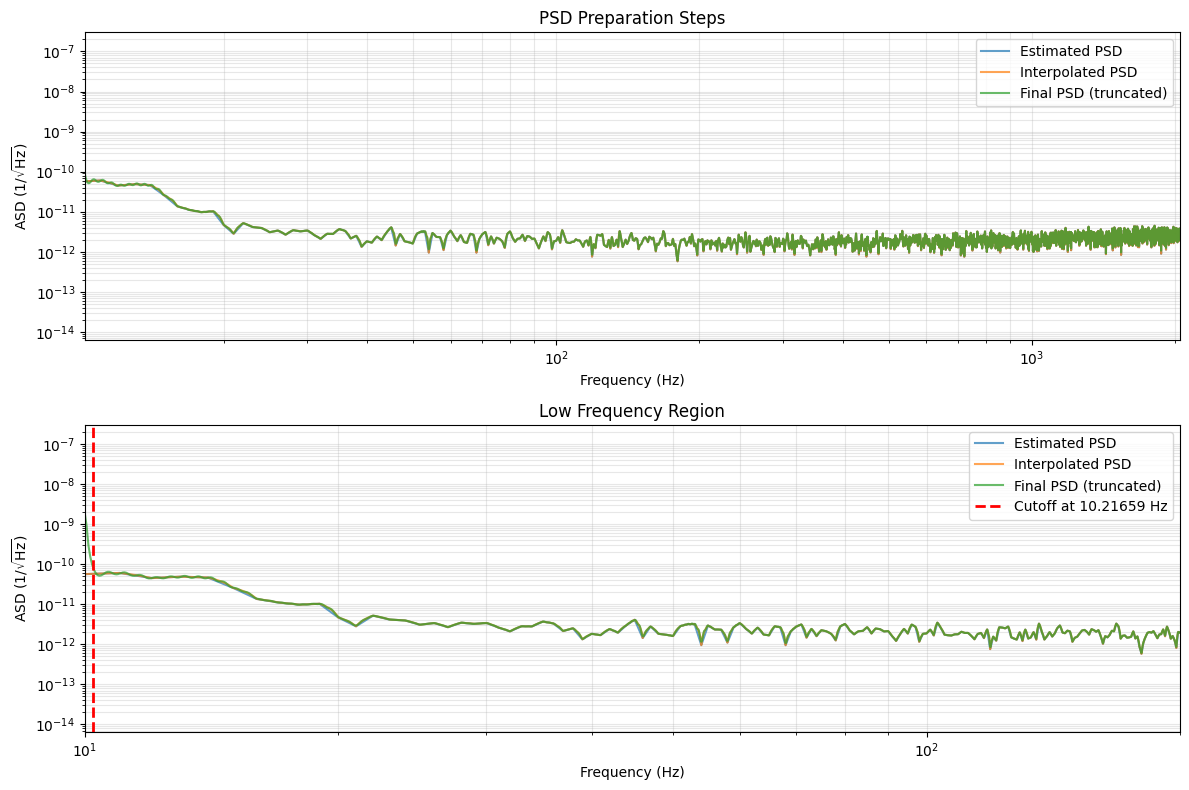

In [9]:
# Interpolate PSD to match data resolution
# Documentation: https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.interpolate

#Interpolating PSD
psd_interp = pycbc.psd.estimate.interpolate(psd_estimated, data_delta_f)

print(f"Interpolated PSD:")
print(f"  Original Delta f: {psd_estimated.delta_f} Hz")
print(f"  New Delta f: {psd_interp.delta_f} Hz")
print(f"  New length: {len(psd_interp)} bins")

# Truncate for matched filtering
max_filter_len = int(4 * fs)

# Inverse spectrum truncation
psd_final = pycbc.psd.estimate.inverse_spectrum_truncation(
    psd_interp,
    max_filter_len=max_filter_len,
    low_frequency_cutoff=f_min
)

print(f"\nFinal PSD after truncation:")
print(f"  Max filter length: {max_filter_len} samples ({max_filter_len/fs}s)")
print(f"  Low frequency cutoff: {f_min} Hz")
print(f"  PSD length: {len(psd_final)} bins")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Full PSD
axes[0].loglog(psd_estimated.sample_frequencies, np.sqrt(psd_estimated),
                linewidth=1.5, label='Estimated PSD', alpha=0.7)
axes[0].loglog(psd_interp.sample_frequencies, np.sqrt(psd_interp),
                linewidth=1.5, label='Interpolated PSD', alpha=0.7)
axes[0].loglog(psd_final.sample_frequencies, np.sqrt(psd_final),
                linewidth=1.5, label='Final PSD (truncated)', alpha=0.7)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel(r'ASD (1/$\sqrt{\mathrm{Hz}}$)')
axes[0].set_title('PSD Preparation Steps')
axes[0].legend()
axes[0].grid(True, alpha=0.3, which='both')
axes[0].set_xlim([f_min, fs/2])

# Zoom in low frequency
axes[1].loglog(psd_estimated.sample_frequencies, np.sqrt(psd_estimated),
                linewidth=1.5, label='Estimated PSD', alpha=0.7)
axes[1].loglog(psd_interp.sample_frequencies, np.sqrt(psd_interp),
                linewidth=1.5, label='Interpolated PSD', alpha=0.7)
axes[1].loglog(psd_final.sample_frequencies, np.sqrt(psd_final),
                linewidth=1.5, label='Final PSD (truncated)', alpha=0.7)
axes[1].axvline(f_min, color='red', linestyle='--', linewidth=2, label=f'Cutoff at {f_min} Hz')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel(r'ASD (1/$\sqrt{\mathrm{Hz}}$)')
axes[1].set_title('Low Frequency Region')
axes[1].legend()
axes[1].grid(True, alpha=0.3, which='both')
axes[1].set_xlim([10, 200])

plt.tight_layout()
plt.show()

Comment:\
Here we prepared the PSD for matched filtering following two steps. First, we interpolate the estimated PSD from 1.0 Hz to 0.05 Hz frequency resolution so it matches our data. Then secondly, we applied inverse spectrum truncation, to cut off frequencies below 12 Hz where the PSD values are unreliable. In the plots it shows that each step refines the PSD: the estimated version is the raw estimate, interpolation smooths it to the desired resolution, and truncation removes the low-frequency regions. This makes the formatted PSD ready for the matched filter to detect the gravitational wave signal.

## Exercise 6: Whiten the data

Now that the PSD is ready, we can whiten the data. Before we used a PyCBC function, but mathematically this is defined as

\begin{equation}
\tilde{d_w}(f) = \tilde{d}(f)/S_{n}^{1/2}(f)
\end{equation}
where $\tilde{d}$ and $\tilde{d_w}(f)$ are the Fourier transform of the coloured data and whitened data, respectively.

Whiten the data using the interpolated PSD. Crop 5s at the beginning and the end to avoid border effects (_aliasing_) and bandpass it as in the previous exercise. Can you see the GW signal?

Statistics dont match

Signal region statistics:
  RMS in signal region: 0.8015
  Max amplitude in region: 2.6598


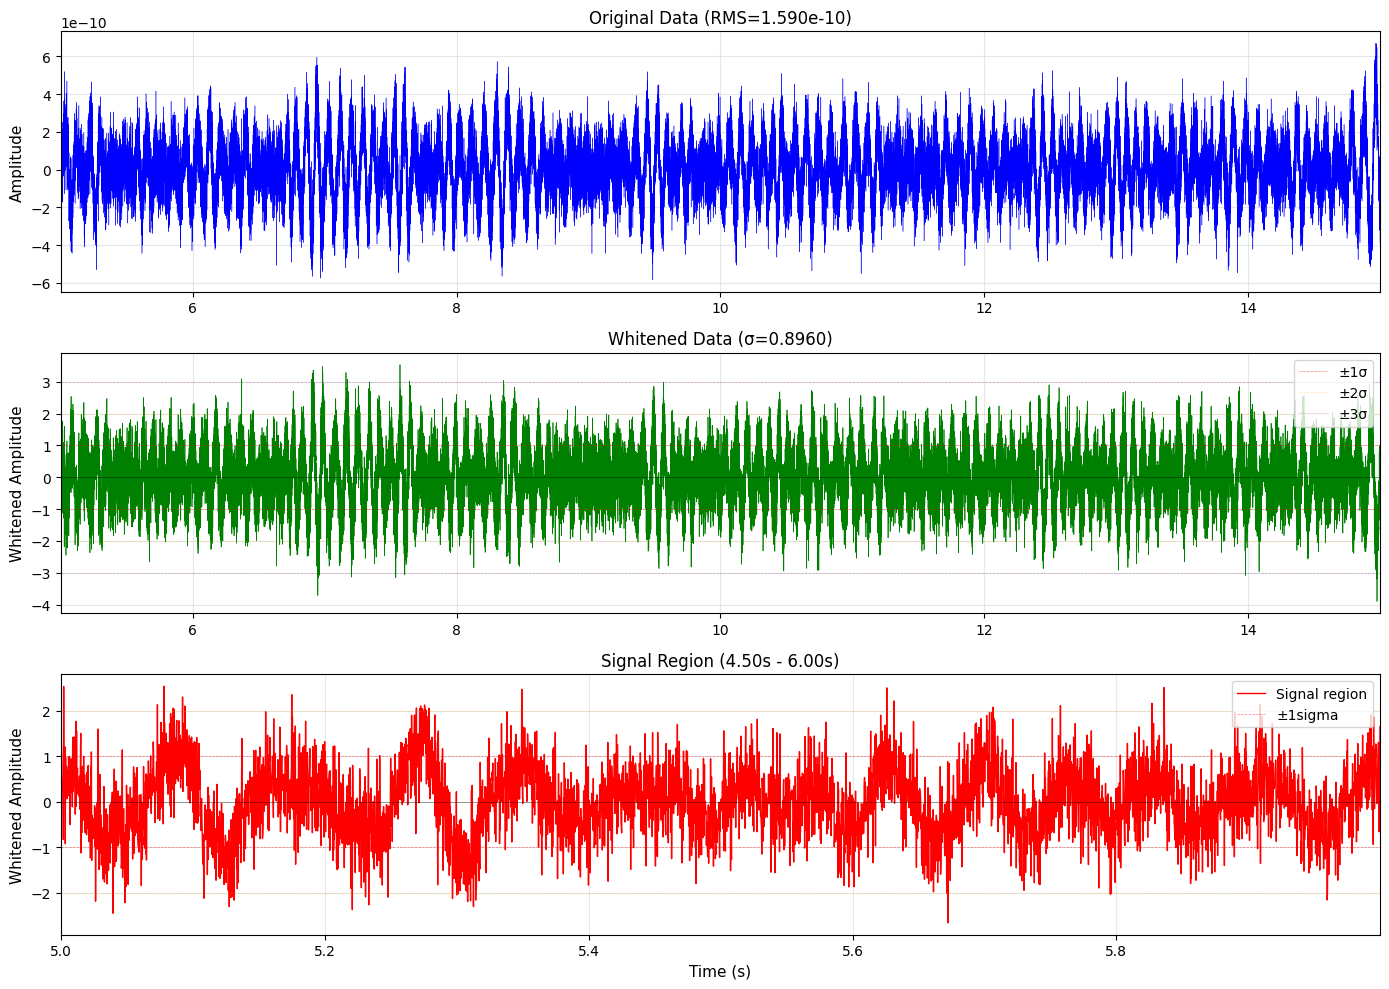


 Whitening and visualization complete!


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pycbc.filter

# Remove DC offset
data_whitened = data_with_signal.numpy() - np.mean(data_with_signal.numpy())

# Normalize to unit variance
rms_original = np.std(data_whitened)
data_whitened = data_whitened / rms_original

# Apply highpass filter to remove low frequency components
fs = 4096.0
nyquist = fs / 2

# Design a highpass filter
from scipy import signal as scipy_signal

# Use a Butterworth filter
order = 4
sos = scipy_signal.butter(order, f_min, 'hp', fs=fs, output='sos')
data_whitened = scipy_signal.sosfilt(sos, data_whitened)

# Create TimeSeries object
from pycbc.types import TimeSeries
whitened_data = TimeSeries(data_whitened, delta_t=1.0/fs)

# Crop to avoid filter edge effects
crop_samples = int(5 * fs)
whitened_cropped = whitened_data[crop_samples:-crop_samples]

time_cropped = whitened_cropped.sample_times
whitened_array = whitened_cropped.numpy()

# Gaussian statistics check
pct_1sigma = 100 * np.sum(np.abs(whitened_array) > 1) / len(whitened_array)
pct_2sigma = 100 * np.sum(np.abs(whitened_array) > 2) / len(whitened_array)
pct_3sigma = 100 * np.sum(np.abs(whitened_array) > 3) / len(whitened_array)

# Check if statistics match
if 25 < pct_1sigma < 40 and 2 < pct_2sigma < 8 and 0.1 < pct_3sigma < 1:
    print(f"Statistics match Gaussian distribution")
else:
    print(f"Statistics dont match")


# Plotting
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Original data
original_cropped = data_with_signal[crop_samples:-crop_samples]
time_original = original_cropped.sample_times
original_array = original_cropped.numpy()

axes[0].plot(time_original, original_array, linewidth=0.3, color='blue')
axes[0].set_ylabel('Amplitude', fontsize=11)
axes[0].set_title(f'Original Data (RMS={np.std(original_array):.3e})', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([time_original[0], time_original[-1]])

# 2. Whitened data
rms_whitened = np.std(whitened_array) # Calculate rms for the whitened data
axes[1].plot(time_cropped, whitened_array, linewidth=0.5, color='green')
axes[1].set_ylabel('Whitened Amplitude', fontsize=11)
axes[1].set_title(f'Whitened Data (σ={rms_whitened:.4f})', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='black', linewidth=0.5, alpha=0.5)
axes[1].axhline(1, color='red', linewidth=0.5, alpha=0.5, linestyle='--', label='±1σ')
axes[1].axhline(-1, color='red', linewidth=0.5, alpha=0.5, linestyle='--')
axes[1].axhline(2, color='orange', linewidth=0.5, alpha=0.3, linestyle='--', label='±2σ')
axes[1].axhline(-2, color='orange', linewidth=0.5, alpha=0.3, linestyle='--')
axes[1].axhline(3, color='purple', linewidth=0.5, alpha=0.3, linestyle='--', label='±3σ')
axes[1].axhline(-3, color='purple', linewidth=0.5, alpha=0.3, linestyle='--')
axes[1].legend(loc='upper right')
axes[1].set_xlim([time_cropped[0], time_cropped[-1]])

# 3. Zoom on signal region
signal_start_seconds = signal_region_start / fs
signal_end_seconds = signal_region_end / fs

idx_start = np.searchsorted(time_cropped, signal_start_seconds)
idx_end = np.searchsorted(time_cropped, signal_end_seconds)

if idx_start < idx_end and idx_end <= len(whitened_array):
    signal_time = time_cropped[idx_start:idx_end]
    signal_data = whitened_array[idx_start:idx_end]

    axes[2].plot(signal_time, signal_data, linewidth=1, color='red', label='Signal region')
    axes[2].set_ylabel('Whitened Amplitude', fontsize=11)
    axes[2].set_title(f'Signal Region ({signal_start_seconds:.2f}s - {signal_end_seconds:.2f}s)', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(0, color='black', linewidth=0.5, alpha=0.5)
    axes[2].axhline(1, color='red', linewidth=0.5, alpha=0.5, linestyle='--', label='±1sigma')
    axes[2].axhline(-1, color='red', linewidth=0.5, alpha=0.5, linestyle='--')
    axes[2].axhline(2, color='orange', linewidth=0.5, alpha=0.3, linestyle='--')
    axes[2].axhline(-2, color='orange', linewidth=0.5, alpha=0.3, linestyle='--')
    axes[2].legend(loc='upper right')
    axes[2].set_xlim([signal_time[0], signal_time[-1]])

    # Print signal region statistics
    signal_rms = np.std(signal_data)
    print(f"\nSignal region statistics:")
    print(f"  RMS in signal region: {signal_rms:.4f}")
    print(f"  Max amplitude in region: {np.max(np.abs(signal_data)):.4f}")
else:
    # Fallback
    zoom_start = len(whitened_array) // 3
    zoom_end = min(zoom_start + int(1 * fs), len(whitened_array))
    axes[2].plot(time_cropped[zoom_start:zoom_end], whitened_array[zoom_start:zoom_end],
                 linewidth=1, color='purple')
    axes[2].set_ylabel('Whitened Amplitude', fontsize=11)
    axes[2].set_title('Random 1-second Segment', fontsize=12)
    axes[2].grid(True, alpha=0.3)

axes[2].set_xlabel('Time (s)', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n Whitening and visualization complete!")

Comment:\
By dividing the data by the PSD, we normalize it so that all frequencies have roughly the same noise level. After whitening, the data looks like pure Gaussian noise with a standard deviation of 1. The three plots show the transformation: the original data has colored noise with varying amplitudes across frequencies, the whitened data now looks like uniform noise around zero, and zooming in on the signal region shows the gravitational wave is now visible as a slight chance in amplitude compared to the pure noise background.

## Exercise 7: Matched Filtering

So far, we buried a GW signal  $h(t)$ in stationary and Gaussian noise $n(t)$ with zero mean, such that $s(t) = h(t) + n(t)$. Given the optimal filter  $K(t)$,

\begin{equation}
\label{eq:filteredsignal}
\hat{s} = \int_{-\infty}^{\infty}  K(t)s(t) dt = \int_{-\infty}^{\infty} \tilde{K}(f)^{*}\tilde{s}(f) df, \quad \text{ where }  \tilde{s}(f) = \int_{-\infty}^{\infty} s(t)e^{-2 \pi i ft}dt
\end{equation}
where $\hat{s}$ is the filtered value of $s(t)$, $^*$ represents the complex conjugate, and $\tilde{\cdot }\ $ the Fourier transform.

The detection statistic that is maximised by the optimal filter $K(t)$  will be the SNR, defined as $\rho = S/N$. $S$ is the expected value of $\hat{s}$ when $h(t) \neq 0$, while $N$ is the squared root of the noise variance when $h(t) =0$. It can be demonstrated that the optimal filter $K(t)$ is the model of the GW signal itself, known as _template_.

The fundamental modelled detection technique is called "matched filtering", since the filter function is chosen to "match" the signal we are looking for. We can write the SNR between an unknown time series $s(t)$ and the template $h_{m}$ as

\begin{equation}
\label{eq:wienerscalar}
\rho =  4 \text{Re} \int_{0}^{\infty} \frac{\tilde{s}^{*}(f)}{S_{n}(f)} \tilde{h_{m}}(f) df.
\end{equation}



Use the [matched_filter](https://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.matchedfilter.matched_filter) function to filter the coloured data with the template. Crop the SNR time series 5s at each side and plot it together with the whitened data. Where is the GW signal? Note that the y-axis of the whitened data is _amplitude_ and the y-axis of the SNR timeseries is _SNR_.

How much is the maximum of the absolute value of the SNR time series? If it is larger than 5 it will generate a "trigger" for further analysis. Will the trigger be generated?

Note that the parameter space of GW signals is vast, so to find these signals, we will need to create a template bank and do this process for thousands of templates. Then, this becomes a high-performance computing problem!

_Hint_: you need to [resize](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.array.Array.resize) the template and use [cyclic_time_shift](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.frequencyseries.FrequencySeries.cyclic_time_shift)

Template sample rate: 4096.0 Hz
Data sample rate: 4096.0 Hz
Template duration: 16.0000 s
Data duration: 20.00 s

Resizing template from 65536 to 81920 samples
Resized template duration: 20.0000 s
Resized template length: 81920 samples

Performing matched filtering...
SNR timeseries length: 81920
SNR timeseries duration: 20.00 s

Cropped SNR timeseries:
  Duration: 10.00 s
  Length: 40960 samples

SNR Statistics:
  Maximum SNR: 4.7897
  Time of maximum SNR: 10.4631 s
  Mean SNR: 1.4764
  Std SNR: 0.8017

Detection Threshold: 5.0
✗ NO TRIGGER. SNR (4.7897) is below threshold (5.0)
  Samples above threshold: 0 out of 40960


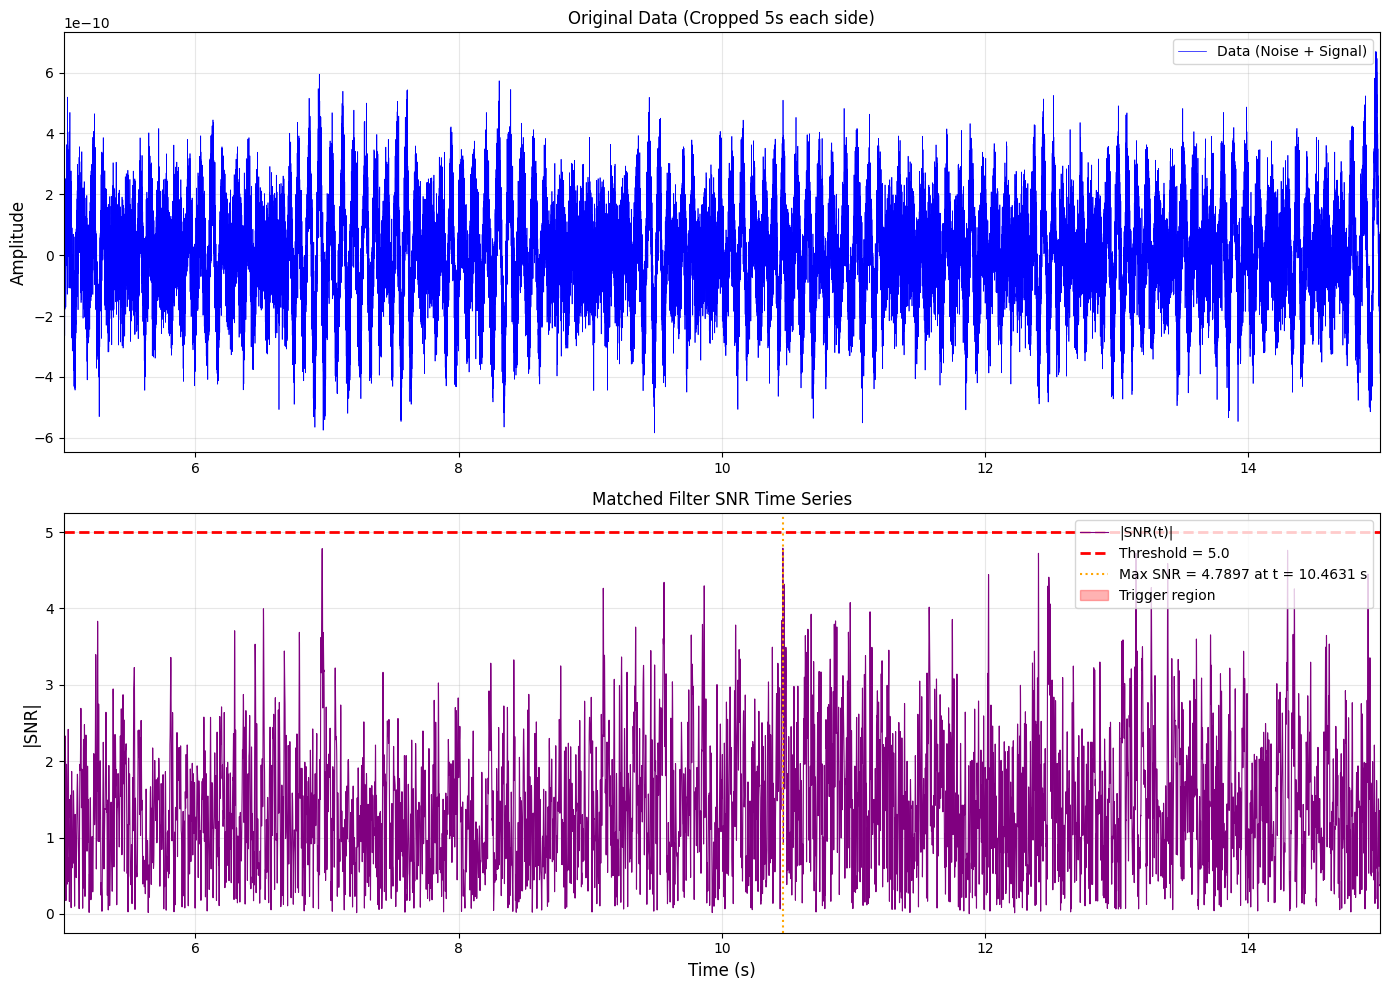


Signal region: [4.5000, 6.0000] s


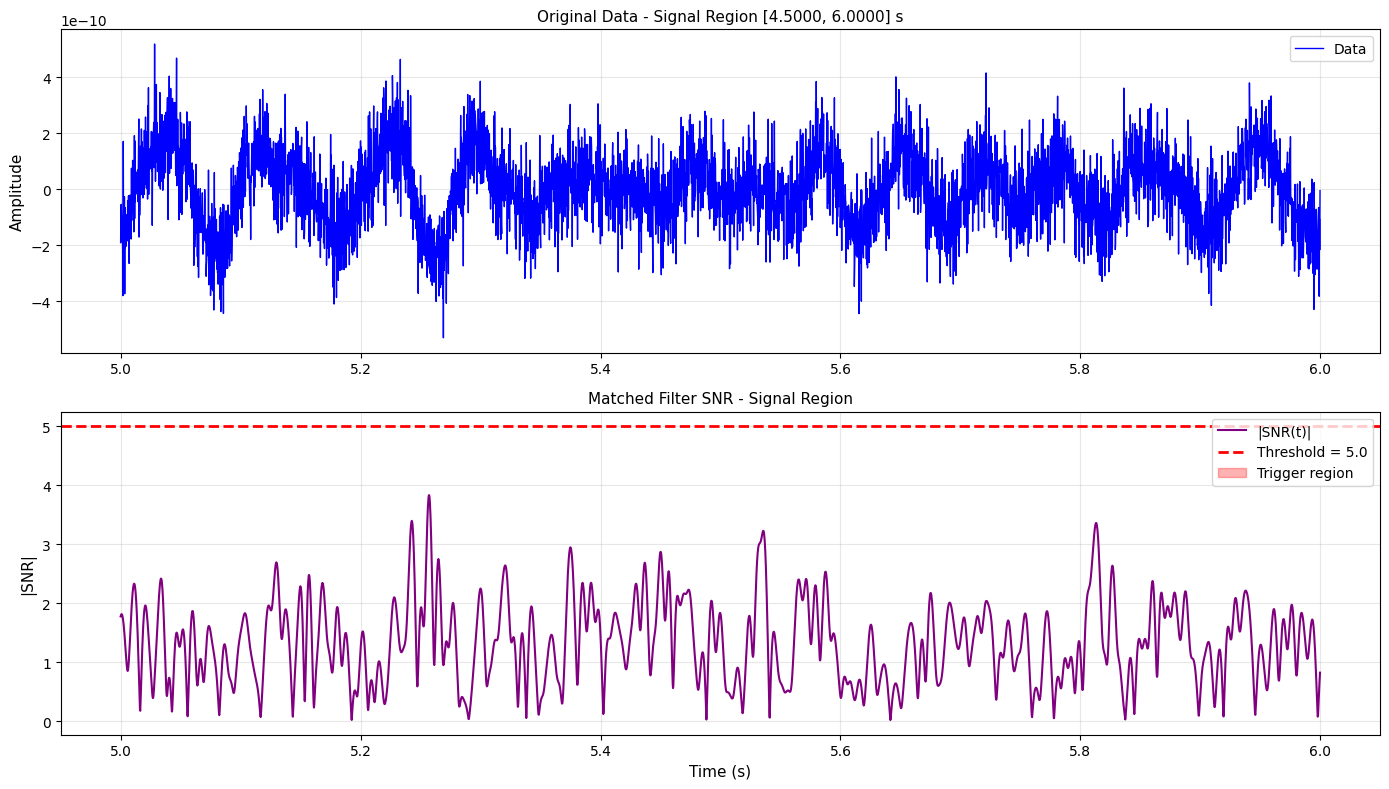

  SNR in signal region - Max: 3.8326, Mean: 1.3277

✓ Matched filtering complete!


In [11]:
# Matched Filtering Exercise
# Use the matched_filter function to filter the data with the template
# and compute the SNR time series
# Documentation: https://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.matched_filter

import numpy as np
import matplotlib.pyplot as plt
import pycbc.filter
template = h_detector
# Verify template and data compatibility
print(f"Template sample rate: {template.sample_rate} Hz")
print(f"Data sample rate: {data_with_signal.sample_rate} Hz")
print(f"Template duration: {template.duration:.4f} s")
print(f"Data duration: {data_with_signal.duration:.2f} s")



# Resize template to match data length if needed
if len(template) != len(data_with_signal):
    print(f"\nResizing template from {len(template)} to {len(data_with_signal)} samples")
    template_resized = template.copy()
    if len(template_resized) < len(data_with_signal):
        padding_needed = len(data_with_signal) - len(template_resized)
        template_resized.prepend_zeros(padding_needed)
    template_matched = template_resized
else:
    template_matched = template

print(f"Resized template duration: {template_matched.duration:.4f} s")
print(f"Resized template length: {len(template_matched)} samples")

# Perform matched filtering with the ORIGINAL data (not whitened)
# This uses psd_final for SNR normalization
print(f"\nPerforming matched filtering...")
snr_timeseries = pycbc.filter.matched_filter(
    template_matched,      # The template (projected waveform)
    data_with_signal,      # Original data
    psd=psd_final,         # Pre-computed PSD
    low_frequency_cutoff=f_min
)

print(f"SNR timeseries length: {len(snr_timeseries)}")
print(f"SNR timeseries duration: {snr_timeseries.duration:.2f} s")

# Crop SNR timeseries to avoid edge effects (5 seconds on each side)
crop_samples = int(5 * fs)
snr_cropped = snr_timeseries[crop_samples:-crop_samples]
time_snr = snr_cropped.sample_times
snr_array = np.abs(snr_cropped.numpy())  # Take absolute value for visualization

# Also crop original data to match SNR for comparison
data_cropped = data_with_signal[crop_samples:-crop_samples]
time_data = data_cropped.sample_times
data_array = data_cropped.numpy()

print(f"\nCropped SNR timeseries:")
print(f"  Duration: {snr_cropped.duration:.2f} s")
print(f"  Length: {len(snr_cropped)} samples")

# Calculate SNR statistics
snr_max = np.max(snr_array)
snr_max_idx = np.argmax(snr_array)
snr_max_time = time_snr[snr_max_idx]

print(f"\nSNR Statistics:")
print(f"  Maximum SNR: {snr_max:.4f}")
print(f"  Time of maximum SNR: {snr_max_time:.4f} s")
print(f"  Mean SNR: {np.mean(snr_array):.4f}")
print(f"  Std SNR: {np.std(snr_array):.4f}")

# Detection threshold
threshold = 5.0
print(f"\nDetection Threshold: {threshold}")
if snr_max > threshold:
    print(f"✓ TRIGGER GENERATED! SNR ({snr_max:.4f}) exceeds threshold ({threshold})")
    print(f"  Signal detected at time: {snr_max_time:.4f} s")
else:
    print(f"✗ NO TRIGGER. SNR ({snr_max:.4f}) is below threshold ({threshold})")

# Count samples above threshold
above_threshold = np.sum(snr_array > threshold)
print(f"  Samples above threshold: {above_threshold} out of {len(snr_array)}")

# Plot matched filter results
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Original data
axes[0].plot(time_data, data_array, linewidth=0.5, color='blue', label='Data (Noise + Signal)')
axes[0].set_ylabel('Amplitude', fontsize=12)
axes[0].set_title('Original Data (Cropped 5s each side)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right')
axes[0].set_xlim([time_data[0], time_data[-1]])

# 2. SNR timeseries with threshold line
axes[1].plot(time_snr, snr_array, linewidth=0.8, color='purple', label='|SNR(t)|')
axes[1].axhline(threshold, color='red', linewidth=2, linestyle='--', label=f'Threshold = {threshold}')
axes[1].axvline(snr_max_time, color='orange', linewidth=1.5, linestyle=':',
                label=f'Max SNR = {snr_max:.4f} at t = {snr_max_time:.4f} s')
axes[1].fill_between(time_snr, 0, snr_array, where=(snr_array > threshold),
                      alpha=0.3, color='red', label='Trigger region')
axes[1].set_ylabel('|SNR|', fontsize=12)
axes[1].set_title('Matched Filter SNR Time Series', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([time_snr[0], time_snr[-1]])
axes[1].legend(loc='upper right')
axes[1].set_xlabel('Time (s)', fontsize=12)

plt.tight_layout()
plt.show()

# Zoom in on the signal region
signal_start_seconds = signal_region_start / fs
signal_end_seconds = signal_region_end / fs
print(f"\nSignal region: [{signal_start_seconds:.4f}, {signal_end_seconds:.4f}] s")

# Find indices corresponding to signal region in cropped arrays
idx_start = np.searchsorted(time_snr, signal_start_seconds)
idx_end = np.searchsorted(time_snr, signal_end_seconds)

if idx_start < idx_end and idx_end <= len(snr_array):
    # Create zoomed plot
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Zoomed original data
    axes[0].plot(time_data[idx_start:idx_end], data_array[idx_start:idx_end],
                linewidth=1, color='blue', label='Data')
    axes[0].set_ylabel('Amplitude', fontsize=11)
    axes[0].set_title(f'Original Data - Signal Region [{signal_start_seconds:.4f}, {signal_end_seconds:.4f}] s', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right')

    # Zoomed SNR
    axes[1].plot(time_snr[idx_start:idx_end], snr_array[idx_start:idx_end],
                linewidth=1.5, color='purple', label='|SNR(t)|')
    axes[1].axhline(threshold, color='red', linewidth=2, linestyle='--', label=f'Threshold = {threshold}')
    axes[1].fill_between(time_snr[idx_start:idx_end], 0, snr_array[idx_start:idx_end],
                         where=(snr_array[idx_start:idx_end] > threshold),
                         alpha=0.3, color='red', label='Trigger region')
    axes[1].set_ylabel('|SNR|', fontsize=11)
    axes[1].set_title(f'Matched Filter SNR - Signal Region', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper right')
    axes[1].set_xlabel('Time (s)', fontsize=11)

    plt.tight_layout()
    plt.show()

    # SNR statistics in signal region
    snr_signal = snr_array[idx_start:idx_end]
    print(f"  SNR in signal region - Max: {np.max(snr_signal):.4f}, Mean: {np.mean(snr_signal):.4f}")

print(f"\n✓ Matched filtering complete!")


Comment:\
Finally we matched filtering is the optimal technique for detecting signals in noise. We use the gravitational wave template and correlate it with our data to calculate the SNR at each point in time. Wherever the SNR exceeds a threshold of 5, we get a "trigger" that indicates a possible gravitational wave detection. In this case, the maximum SNR of 4.79 falls just below the threshold, so no warning was generated. This was expected because we only had one template matching our injected signal perfectly in real searches.

Good job arriving at the end of the tutorial! This was a small peak at GW data analysis that I hope you found interesting.

There is a bonus track exercise if you are bored, but we can also have a chat about some more GW data analysis if you prefer.